In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from pathlib import Path
import h5py
import began
from began.logging import setup_vae_run_logging
from IPython import display
from matplotlib.ticker import MaxNLocato
import xarray as xa
from began.visualization import mplot, plot
%matplotlib inline
print("Working with GPU: ", tf.test.is_gpu_available())

ModuleNotFoundError: No module named 'began'

In [3]:
DATA_DIR = Path("/oasis/scratch/comet/bthorne/temp_project/flat-maps")


# Hyperparameters of architecture and training
hyperparameters = {
    'LAT_DIM': 128,
    'BATCH_SIZE': 16,
    'EPOCHS': 50,
    'NUM_EXAMPLES_TO_GENERATE': 4,
}
summary_writer = setup_vae_run_logging(hyperparameters)

NameError: name 'setup_vae_run_logging' is not defined

In [8]:
# Batch and shuffle the data
RES = 256
record_dir = Path("../data/preprocessed/")
fpath = record_dir / "GNILC_dust_map_{:d}_st{:d}_gcut{:d}.npy".format(RES, int(STEP_SIZE), int(GAL_CUT))

train_images = np.load(fpath).astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(hyperparameters['BATCH_SIZE'])

test_dataset = dataset.take(100) 
train_dataset = dataset.skip(100)

In [9]:
@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = began.vae.compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

def generate_and_save_images(model, epoch, test_input, title=None):
    predictions = model.sample(test_input)
    mean = np.mean(predictions)
    std = np.std(predictions)
    fig = mplot(predictions[..., 0], extent=(-10, 10, -10, 10), title=title, cbar_range=[mean - 2*std, mean+2*std])
    fig.savefig('plots/vae/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [10]:
optimizer = tf.keras.optimizers.Adam(beta_1=0.5, learning_rate=5e-4)
model = began.CVAE(hyperparameters['LAT_DIM'])

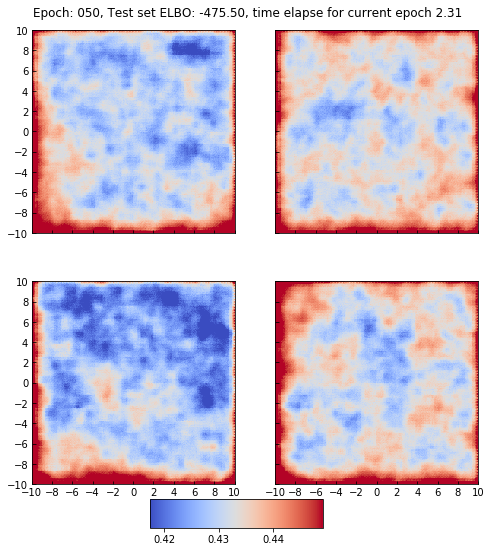

In [11]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[hyperparameters['NUM_EXAMPLES_TO_GENERATE'], hyperparameters['LAT_DIM']])

for epoch in range(1, hyperparameters['EPOCHS'] + 1):
    print("Epoch: ", epoch)
    start_time = time.time()
    for step, train_x in enumerate(train_dataset):
        print(np.mean(train_x))
        print(np.std(train_x))
        compute_apply_gradients(model, train_x, optimizer)
        
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
          loss(began.vae.compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        
        with summary_writer.as_default():
            tf.summary.scalar('elbo', elbo, step=epoch)
        title = 'Epoch: {:03d}, Test set ELBO: {:04.02f}, time elapse for current epoch {:02.02f}'.format(epoch, elbo, end_time - start_time)
        generate_and_save_images(model, epoch, random_vector_for_generation, title)

In [31]:
model.save_weights('/home/bthorne/projects/gan/began/models/vae.h5')

In [12]:
anim_file = 'plots/vae/vae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('plots/vae/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [13]:
encoded_training_data = np.array([np.array(model.encode(img)) for img in train_dataset])

In [15]:
encoded_training_data = np.empty((1840, 128))
i = 0
for train_images in train_dataset:
    for img in train_images:
        encoded_training_data[i] = model.encode(img[None, ...])[1]
        i += 1

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+01,
        2.40000e+01, 2.30000e+01, 1.80000e+01, 3.00000e+01, 4.50000e+01,
        1.31000e+02, 1.36000e+02, 1.81000e+02, 2.09000e+02, 2.93000e+02,
        6.74000e+02, 1.24000e+03, 1.70600e+03, 2.43700e+03, 3.47600e+03,
        3.62800e+03, 6.67700e+03, 7.50800e+03, 2.06871e+05, 1.83000e+02,
        2.00000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00]),
 array([-10. ,  -9.7,  -9.4,  -9.1,  -8.8,  -8.5,  -8.2,  -7.9,  -7.6,
         -7.3,  -7. ,  -6.7,  -6.4,  -6.1,  -5.8,  -5.5,  -5.2,  -4.9,
         -4.6,  -4.3,  -4. ,  -3.7,  -3.4,  -3.1,  -2.8,  -2.5,  -2.2,
         -1.9,  -1.6,  -1.3,  -1. ,  -0.7,  -0.4,  -0.1

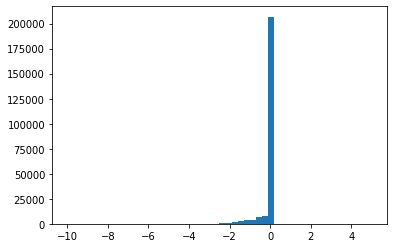

In [16]:
plt.hist(encoded_training_data.flatten(), range=[-10, 5], bins=50)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.600e+01, 4.300e+01, 5.000e+01, 4.200e+01,
        4.500e+01, 1.800e+01, 1.000e+01, 7.000e+00, 3.000e+00, 0.000e+00,
        1.599e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,

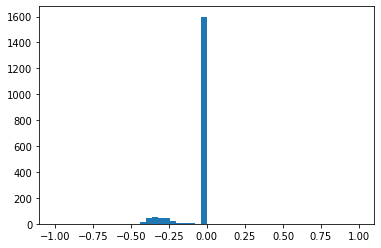

In [22]:
plt.hist(encoded_training_data[:, 49], range=[-1, 1], bins=50)

In [23]:
import pymaster as nmt

In [24]:
pred_maps = np.array(model.decode(np.random.randn(100, latent_dim)))
print(pred_maps.shape)

NameError: name 'latent_dim' is not defined

In [25]:
xlen = 10
ylen = 10
xres = 256
yres = 256

In [26]:
Lx = 2 * xlen * np.pi/180
Ly = 2 * ylen * np.pi/180
Nx = xres
Ny = yres


In [27]:
mask = np.ones(Nx * Ny).reshape((Nx, Ny))
xarr = np.ones(Ny)[:, None] * np.arange(Nx)[None, :] * Lx/Nx
yarr = np.ones(Nx)[None, :] * np.arange(Ny)[:, None] * Ly/Ny

In [ ]:
mask = nmt.mask_apodization_flat(mask, Lx, Ly, aposize=1., apotype="C1")

In [ ]:
f0 = nmt.NmtFieldFlat(Lx, Ly, mask, [pred_maps[0, :, :, 0]])
l0_bins = np.arange(Nx/8) * 8 * np.pi/Lx
b = nmt.NmtBinFlat(l0_bins, l0_bins)

In [ ]:
w00 = nmt.NmtWorkspaceFlat()
w00.compute_coupling_matrix(f0, f0, b)

In [ ]:
def get_uncoupled_spectrum(wsp, field0, nmtbin):
    cl_coupled = nmt.compute_coupled_cell_flat(field0, field0, nmtbin)
    return wsp.decouple_cell(cl_coupled)

cl = np.empty((pred_maps.shape[0], b.get_n_bands()))
for i in range(pred_maps.shape[0]):
    field = nmt.NmtFieldFlat(Lx, Ly, mask, [pred_maps[i, :, :, 0]])
    cl[i] = get_uncoupled_spectrum(w00, field, b)
    #field_gen = nmt.NmtFieldFlat(Lx, Ly, mask, [gen_arr_exp[i, :, :, 0]])
    #cl_gen[i] = get_uncoupled_spectrum(w00, field_gen, b)

In [ ]:
ells_uncoupled = b.get_effective_ells()

In [ ]:
fig, ax = plt.subplots(1, 1)
for i in range(pred_maps.shape[0]):
    ax.loglog(ells_uncoupled, cl[i])
ax.set_xlabel(r"$\ell_b$")
ax.set_ylabel(r"$C_\ell$")
ax.set_ylim(1e-11, 1e-7)